In [97]:
import pandas as pd
# from modin.config import Engine
# Engine.put("ray")
# import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as mticker
import matplotlib
import matplotlib.dates as mdates
import numpy as np
import logging
import re
from joblib import Parallel, delayed
import gensim
import gensim.downloader
import gc
import collections
import optuna

optuna.logging.set_verbosity(optuna.logging.ERROR)
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger('nlp')
logger.setLevel(logging.INFO)

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except:
    logger.info('Intel(R) Extension for Scikit-learn* wasn\'t patched.')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, f1_score, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

import xgboost as xgb

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import BatchSampler, RandomSampler
from torch.optim.lr_scheduler import ExponentialLR

from torchmetrics import AUROC, Accuracy, F1Score, ConfusionMatrix

sns.set(font_scale=1.4)
sns.set_style('whitegrid')


%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
train_data = pd.read_csv('archive/train.csv')
valid_data = pd.read_csv('archive/valid.csv')

In [3]:
def date_to_datetime(arg):
    return datetime.strptime(arg, '%Y-%m-%d %H:%M:%S')

In [4]:
train_data['CreationDate'] = train_data['CreationDate'].map(date_to_datetime)
train_data.sort_values('Y', inplace=True)
train_data

,Id,Title,Body,Tags,CreationDate,Y
22972,45310925,How to get a complete topic distribution for a...,<p>When I train my lda model as such</p>\n\n<p...,<python><gensim><lda>,2017-07-25 18:21:31,HQ
10972,39634954,nvm uninstall doesn't actually uninstall the n...,<p>So I'm trying to clear out older versions o...,<node.js><nvm>,2016-09-22 09:16:33,HQ
10974,39635861,Unable to contact local DTServiceHub to bless ...,<p>When I run my basic Xcode project in simula...,<ios><xcode8>,2016-09-22 09:54:23,HQ
10975,39637588,C# How to add a property setter in derived class?,<p>I have a requirement where I have a number ...,<c#><inheritance>,2016-09-22 11:19:19,HQ
10976,39637675,What is the difference between @types.coroutin...,<p>Documentations say:</p>\n\n<blockquote>\n ...,<python><asynchronous><python-3.5>,2016-09-22 11:23:13,HQ
...,...,...,...,...,...,...
31785,50165626,dice number showing with c# on unity 3d,I wrote a code to show the number of the dice ...,<c#><unity3d><3d>,2018-05-04 00:50:45,LQ_EDIT
31784,50163974,powershell generate word list from two csv fil...,I'm trying to use powershell to import two csv...,<powershell><csv>,2018-05-03 21:16:52,LQ_EDIT
13573,40687487,Why this regex is not working?,Test URL:\r\n\r\n www-test1.examples.com\r\...,<java><regex>,2016-11-18 23:28:06,LQ_EDIT
31792,50172042,installing packag (gahgu95av2.db) in R,I have a problem with installing pack (gahgu95...,<r>,2018-05-04 09:48:05,LQ_EDIT


In [5]:
valid_data['CreationDate'] = valid_data['CreationDate'].map(date_to_datetime)
valid_data.sort_values('Y', inplace=True)
valid_data

,Id,Title,Body,Tags,CreationDate,Y
5708,42226798,Remove duplicate data from query results,<p>I have the following query:</p>\n\n<pre><co...,<sql-server><tsql>,2017-02-14 12:56:30,HQ
5841,42394999,Why should I use Validators.compose()?,<p>I have a field I want to validate with mult...,<angular><angular2-forms><angular2-formbuilder>,2017-02-22 14:59:19,HQ
5839,42393545,"How to fix ""Missing Gradle project configurati...","<p>As an Eclipse user, I always liked the Grad...",<eclipse><gradle><configuration><buildship>,2017-02-22 13:58:32,HQ
5838,42390860,Configure active profile in SpringBoot via Maven,<p>I'm trying to set an active profile in Spri...,<java><spring><maven><spring-boot>,2017-02-22 12:01:00,HQ
5836,42389649,'openURL' was deprecated in iOS 10.0: Please u...,<p>I have working open webLink url codes in <c...,<ios><uiwebview><swift3>,2017-02-22 11:12:41,HQ
...,...,...,...,...,...,...
8218,46154987,How avoid recurrent code in block with ruby ?,I try to convert a bash script in a ruby scrip...,<ruby><linux>,2017-09-11 11:45:53,LQ_EDIT
8217,46150920,What is the best way (steps) to implement User...,Trying to use Apache Ignite as in-memory datab...,<java><ignite>,2017-09-11 08:06:24,LQ_EDIT
8214,46147329,Converting lower case hex to uppercase in python,Can anyone please help me in converting a hex ...,<python><string><mac-address>,2017-09-11 02:13:22,LQ_EDIT
8252,46189292,I want to get $username variable from profile....,This is my ajax code:\r\n \r\n\r\n\r\n\r\n ...,<javascript><php><mysql><ajax><fetch>,2017-09-13 05:10:39,LQ_EDIT


# EDA

## Labels distribution

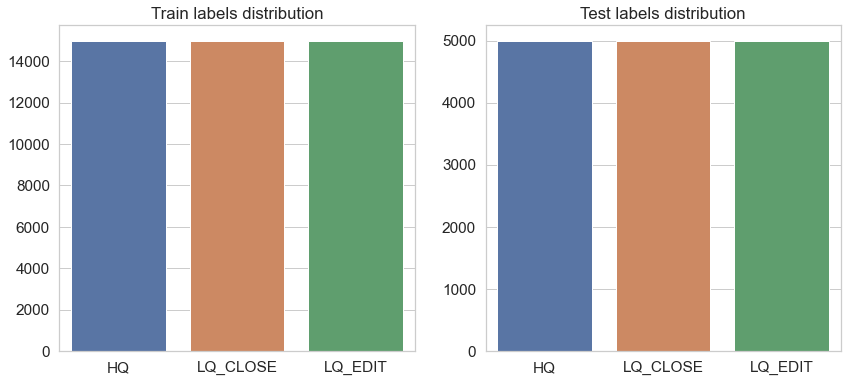

In [6]:
train_Y_vc = train_data['Y'].value_counts()
valid_Y_vc = valid_data['Y'].value_counts()


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=train_Y_vc.index, y=train_Y_vc.values, ax=axes[0])
axes[0].set_title('Train labels distribution')
sns.barplot(x=valid_Y_vc.index, y=valid_Y_vc.values, ax=axes[1])
axes[1].set_title('Test labels distribution')
plt.show()

#### Summary
 - Counts of labels are equal each other for both train and test datasets
 - Train dataset 3x times larger than test

In [7]:
datasets = [('Train', train_data), ('Test', valid_data)]

## Dates distribution

### Days distribution

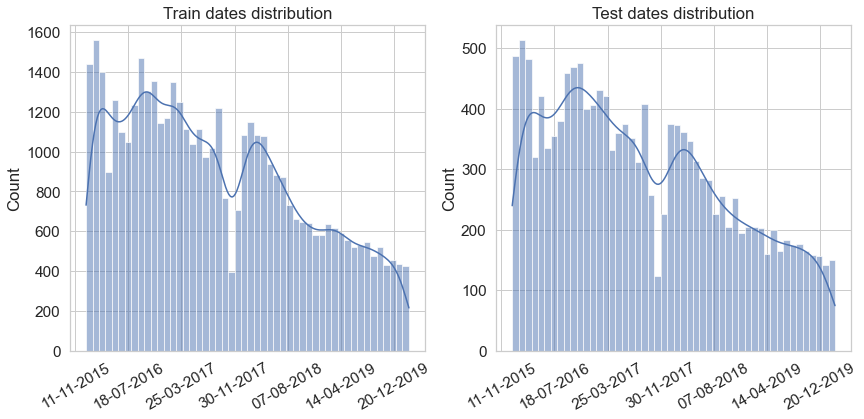

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset['CreationDate'].sort_values()
    def get_date(arg):
        return arg.date()
    CD_data_mapped = CD_data.map(get_date)
    sns.histplot(x=mdates.date2num(CD_data_mapped), bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f'{dataset_name} dates distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%d-%m-%Y')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

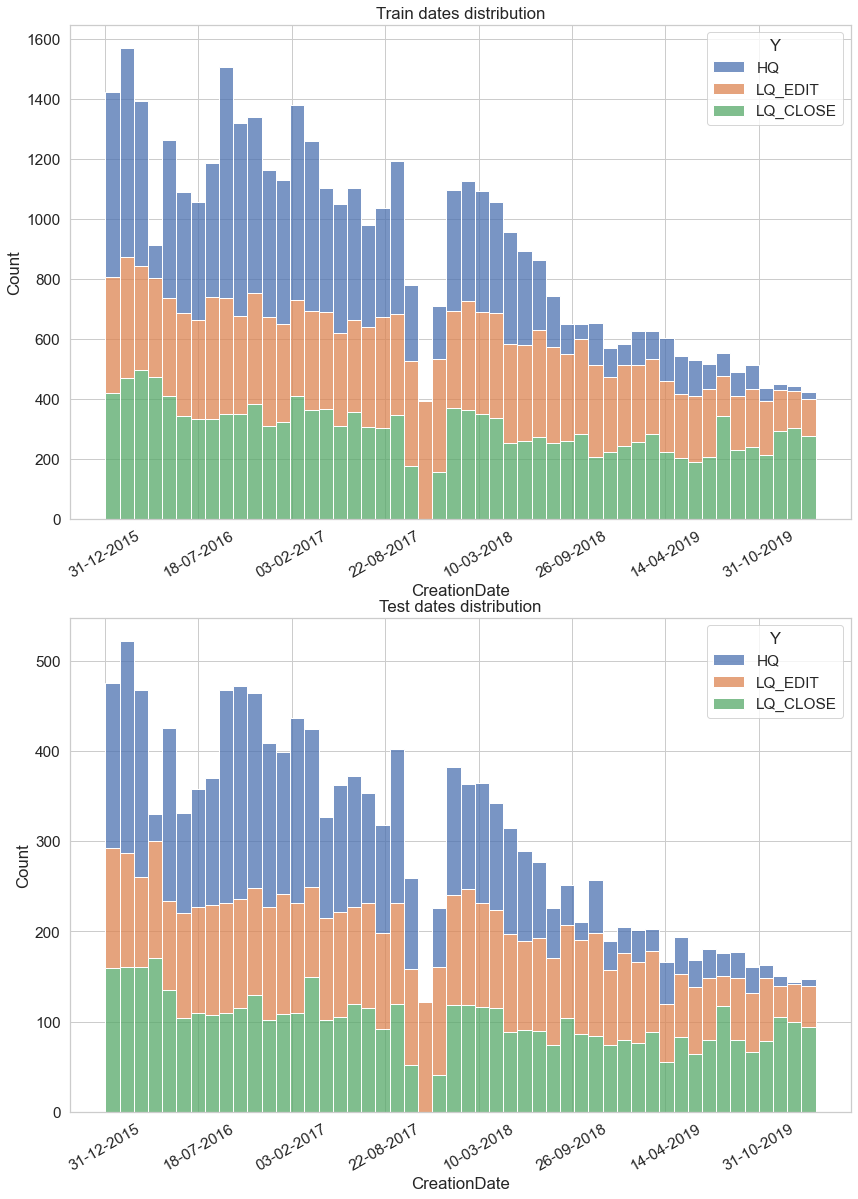

In [9]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']
anomaly_timeframes = {}

def search_anomaly_timeframe_bounds(CD_data):
    max_length = 0
    current_length = 0
    is_in_sector = False
    start_sector_idx = None
    max_start_sector_idx = None
    max_finish_sector_idx = None
    CD_data = CD_data.copy()
    for index, row in CD_data.iterrows():
        if row['Y'] == 'LQ_EDIT':
            if is_in_sector:
                current_length += 1
            else:
                is_in_sector = True
                current_length = 1
                start_sector_idx = index
        else:
            if current_length > max_length:
                max_length = current_length
                max_start_sector_idx = start_sector_idx
                max_finish_sector_idx = index
            is_in_sector = False
    return CD_data['CreationDate'][max_start_sector_idx], CD_data['CreationDate'][max_finish_sector_idx]
    
fig, axes = plt.subplots(2, 1, figsize=(14, 20))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset[['CreationDate', 'Y']].copy()
    CD_data.sort_values(by=['CreationDate'], inplace=True)
    anomaly_timeframes[dataset_name] = search_anomaly_timeframe_bounds(CD_data)
    CD_data['CreationDate'] = mdates.date2num(CD_data['CreationDate'])
    sns.histplot(data=CD_data, x='CreationDate', bins=50, multiple='stack', hue='Y', ax=axes[idx], 
                 palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} dates distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%d-%m-%Y')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

In [10]:
print('Timeframes with only LQ_EDIT samples:')
for key, value in anomaly_timeframes.items():
    print(f'{key} dataset : [{value[0]}, {value[1]}]')

Timeframes with only LQ_EDIT samples:
Train dataset : [2017-10-17 08:06:29, 2017-12-15 16:32:28]
Test dataset : [2017-10-17 05:57:57, 2017-12-15 18:01:33]


#### Summary
 - The graphs show the decrease in the number of HQ labels over time
 - Timeframe with only LQ_EDIT exists in both train and test datasets

### Daytimes distribution

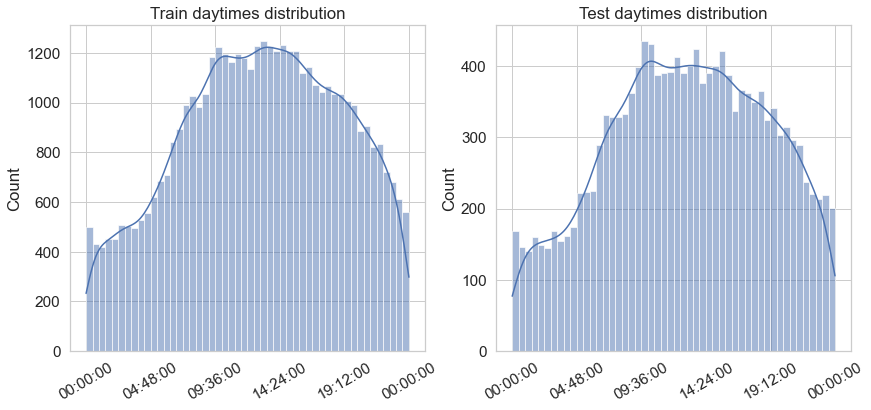

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset['CreationDate']
    def get_daytime(arg):
        str_time = arg.replace(year=2020, day=1, month=1)
        return str_time
    CD_data_mapped = CD_data.map(get_daytime).sort_values()
    sns.histplot(x=mdates.date2num(CD_data_mapped), bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f'{dataset_name} daytimes distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%H:%M:%S')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

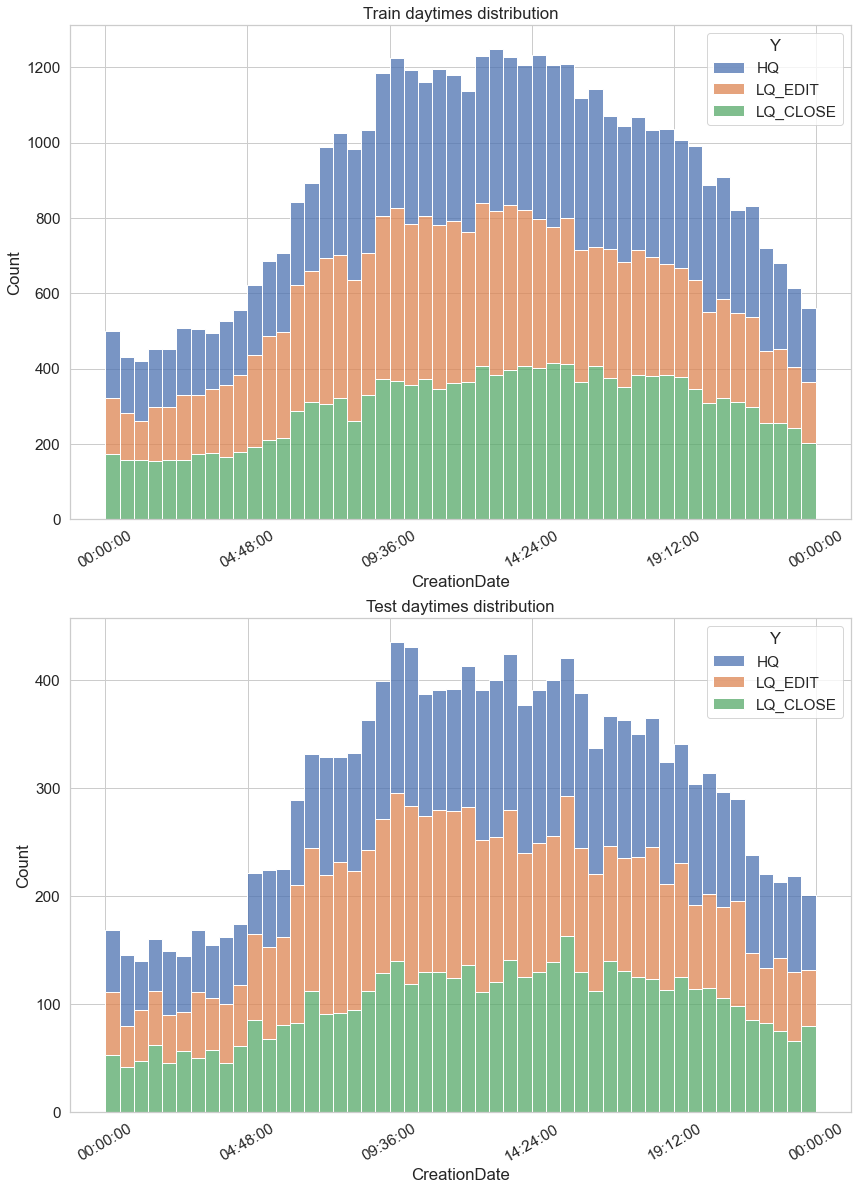

In [12]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']

fig, axes = plt.subplots(2, 1, figsize=(14, 20))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset[['CreationDate', 'Y']].copy()
    def get_daytime(arg):
        str_time = arg.replace(year=2020, day=1, month=1)
        return str_time
    CD_data['CreationDate'] = CD_data['CreationDate'].map(get_daytime)
    CD_data.sort_values(by=['CreationDate'])
    CD_data['CreationDate'] = mdates.date2num(CD_data['CreationDate'])
    sns.histplot(data=CD_data, x='CreationDate', bins=50, multiple='stack', hue='Y', ax=axes[idx],
                palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} daytimes distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%H:%M:%S')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

#### Summary
 - No insights

## Tags
### Find intersection of train and test datasets

In [13]:
def get_tags_counts(T_data):
    tags_dict = {}
    for item in T_data:
        if item[0] != '<' or item[-1] != '>':
            logger.error(f'Wrong format of tag: {item}')
            sys.exit(1)
        local_tags = item[1:-1].split('><')
        local_tags_set = set()
        for local_tag in local_tags:
            if local_tag in local_tags_set:
                continue
            local_tags_set.add(local_tag)
            if local_tag not in tags_dict.keys():
                tags_dict[local_tag] = 0
            tags_dict[local_tag] += 1
    return dict(sorted(tags_dict.items(), key=lambda item: -item[1]))

tags_dicts = {}
overall_keys = None

for idx, (dataset_name, dataset) in enumerate(datasets):
    T_data = dataset['Tags'].copy()
    tags_counts = get_tags_counts(T_data)
    print(f'Top 5 tags ({dataset_name} dataset):', sorted(tags_counts.items(), key=lambda item: -item[1])[:5])
    print(f'Tags count ({dataset_name} dataset):', len(tags_counts.keys()))
    tags_dicts[dataset_name] = tags_counts
    
overall_keys = tags_dicts['Train'].keys() & tags_dicts['Test'].keys()
print('Size of tags intersection on Train & Test datasets:', 
      len(overall_keys))

Top 5 tags (Train dataset): [('javascript', 5385), ('python', 5041), ('java', 4677), ('android', 3573), ('c#', 3137)]
Tags count (Train dataset): 9336
Top 5 tags (Test dataset): [('python', 1759), ('javascript', 1721), ('java', 1565), ('android', 1265), ('php', 1036)]
Tags count (Test dataset): 5401
Size of tags intersection on Train & Test datasets: 4034


### Get "tag X class" counts

In [14]:
overall_tags = []
overall_tags_df = {}

def init_stage_overall_tags():
    stage_overall_tags = {}
    for key in overall_keys:
        stage_overall_tags[key] = {}
        stage_overall_tags[key]['HQ'] = 0
        stage_overall_tags[key]['LQ_EDIT'] = 0
        stage_overall_tags[key]['LQ_CLOSE'] = 0
    return stage_overall_tags
    
for idx, (dataset_name, dataset) in enumerate(datasets):
    overall_tags.append(init_stage_overall_tags())
    stage_overall_tags = overall_tags[-1]
    T_data = dataset[['Tags', 'Y']].copy()
    for index, row in T_data.iterrows():
        tags = set(row['Tags'][1:-1].split('><'))
        for tag in tags:
            if tag in overall_keys:
                stage_overall_tags[tag][row['Y']] += 1
    overall_tags_df[dataset_name] = pd.DataFrame.from_dict(stage_overall_tags, orient='index')
    print(f'{dataset_name} tags:')
    print(overall_tags_df[dataset_name])
    

Train tags:
                      HQ  LQ_EDIT  LQ_CLOSE
tensorflow-gpu         3        0         0
installation          21        7         8
intellisense           8        1         0
range                  4       10         5
uppercase              2        1         2
...                   ..      ...       ...
distribution           0        0         1
worksheet-function     0        1         0
admin                  2        1         1
algebraic-data-types   2        1         0
android-tablayout      2        3         0

[4034 rows x 3 columns]
Test tags:
                      HQ  LQ_EDIT  LQ_CLOSE
tensorflow-gpu         1        0         0
installation           6        4         3
intellisense           3        0         0
range                  0        4         4
uppercase              0        1         0
...                   ..      ...       ...
distribution           0        1         0
worksheet-function     0        1         0
admin                  2    

### Get quantiles of tags counts distribution

In [15]:
for idx, (dataset_name, dataset) in enumerate(datasets):
    def sum_counts(row):
        return sum(row.values[:3])
    tags_counts = overall_tags_df[dataset_name].apply(sum_counts, axis=1)
    overall_tags_df[dataset_name]['Sum'] = tags_counts
    print(overall_tags_df[dataset_name])
    q = tags_counts.quantile(np.linspace(0.9,1,9))
    print(f'{dataset_name} quantiles')
    print(q)

                      HQ  LQ_EDIT  LQ_CLOSE  Sum
tensorflow-gpu         3        0         0    3
installation          21        7         8   36
intellisense           8        1         0    9
range                  4       10         5   19
uppercase              2        1         2    5
...                   ..      ...       ...  ...
distribution           0        0         1    1
worksheet-function     0        1         0    1
admin                  2        1         1    4
algebraic-data-types   2        1         0    3
android-tablayout      2        3         0    5

[4034 rows x 4 columns]
Train quantiles
0.9000      32.0000
0.9125      37.0000
0.9250      45.0000
0.9375      55.9375
0.9500      71.0000
0.9625      95.7625
0.9750     154.0000
0.9875     282.7625
1.0000    5385.0000
dtype: float64
                      HQ  LQ_EDIT  LQ_CLOSE  Sum
tensorflow-gpu         1        0         0    1
installation           6        4         3   13
intellisense           3     

### Summary
 - Most part of tags appear rare. Others appear very often.

### Get good & rare tags

In [16]:
# Drop extra tags for visualization. count_limit provide opportunity to drop rare tags.
count_limit = 200

local_train_data = overall_tags_df['Train']
good_tags_index = local_train_data[local_train_data['Sum'] > count_limit]
rare_tags_index = local_train_data[local_train_data['Sum'] <= count_limit]
print('Good tags')
print(good_tags_index)
print('Tags at all:', sum(good_tags_index['Sum'].values))
good_tags_index = good_tags_index.index
print()
print('Rare tags')
print(rare_tags_index)
print('Tags at all:', sum(rare_tags_index['Sum'].values))
rare_tags_index = rare_tags_index.index

Good tags
               HQ  LQ_EDIT  LQ_CLOSE   Sum
pandas        249       98        71   418
angular       839      137       120  1096
asp.net-core  217       15        23   255
mysql         113      530       523  1166
asp.net-mvc    61       79        77   217
...           ...      ...       ...   ...
firebase      194       82        45   321
php           296     1124      1705  3125
kotlin        252       32        28   312
xcode         227       63        64   354
date           33       80       121   234

[75 rows x 4 columns]
Tags at all: 63413

Rare tags
                      HQ  LQ_EDIT  LQ_CLOSE  Sum
tensorflow-gpu         3        0         0    3
installation          21        7         8   36
intellisense           8        1         0    9
range                  4       10         5   19
uppercase              2        1         2    5
...                   ..      ...       ...  ...
distribution           0        0         1    1
worksheet-function     0     

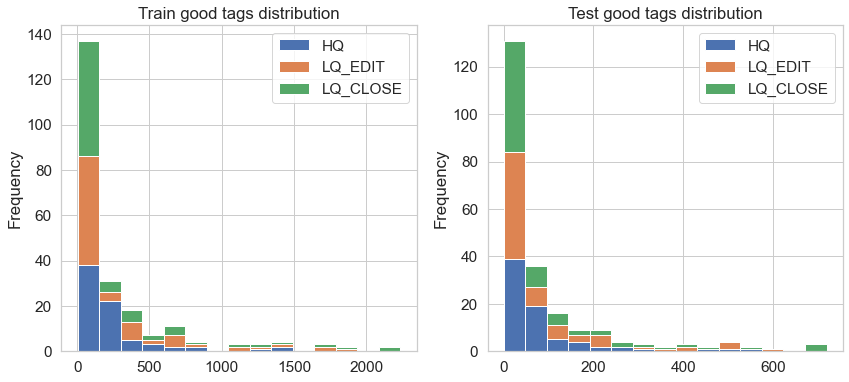

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    local_tags = overall_tags_df[dataset_name].copy().drop(['Sum'], axis=1)
    tags_x_class = local_tags.loc[good_tags_index]
    tags_x_class.plot.hist(bins=15, stacked='True', title=f'{dataset_name} good tags distribution', ax=axes[idx])

In [18]:
good_tags_index

Index(['pandas', 'angular', 'asp.net-core', 'mysql', 'asp.net-mvc', 'bash',
       'android', 'node.js', 'sql-server', 'go', 'c', 'selenium', 'docker',
       'reactjs', 'spring', 'database', 'oracle', 'c#', 'if-statement',
       'algorithm', 'html', '.net', 'ruby-on-rails', 'tensorflow', 'regex',
       'vue.js', 'ios', 'sorting', 'react-native', 'string', 'excel',
       'python-3.x', 'ajax', 'typescript', 'laravel', 'arrays', 'python',
       'wordpress', 'objective-c', 'vba', 'json', 'loops', 'c++', 'linux',
       'jquery', 'git', 'webpack', 'javascript', 'css', 'python-2.7', 'r',
       'function', 'visual-studio-code', 'list', 'windows', 'android-studio',
       'flutter', 'for-loop', 'angularjs', 'asp.net', 'ruby', 'visual-studio',
       'swift', 'java', 'amazon-web-services', 'dictionary', 'django', 'xml',
       'sql', 'spring-boot', 'firebase', 'php', 'kotlin', 'xcode', 'date'],
      dtype='object')

### Analyse rare tags with Gini coef
https://en.wikipedia.org/wiki/Gini_coefficient

In [19]:
def gini_coef(coefs):
    s = sum(coefs)
    arith_mean = s / len(coefs)
    acc = 0
    for i in coefs:
        for j in coefs:
            acc += abs(i - j)
    acc /= (2 * len(coefs) ** 2 * arith_mean)
    return acc

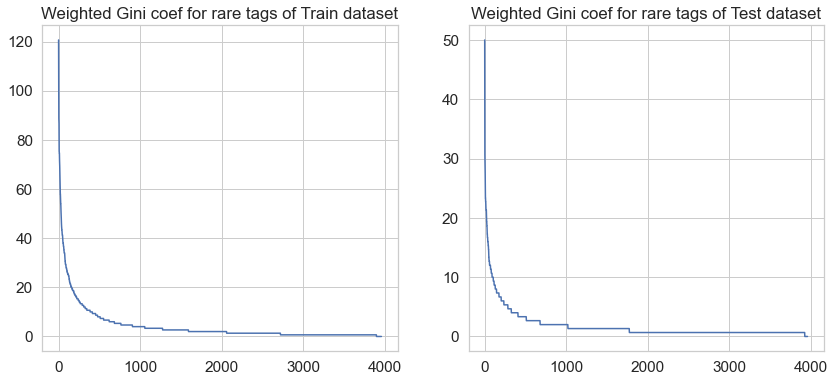

In [20]:
# To prevent overfitting on very-very rare tags we'll multiply Gini coef on sum of coefs
def weighted_gini_coef(coefs):
    return gini_coef(coefs) * sum(coefs)

rare_tags = {}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    local_tags = overall_tags_df[dataset_name].copy().drop(['Sum'], axis=1)
    tags_x_class = local_tags.loc[rare_tags_index]
    rare_tags_scores = tags_x_class.apply(weighted_gini_coef, axis=1).sort_values(ascending=False)
    sns.lineplot(data=rare_tags_scores.values, ax=axes[idx])
    axes[idx].set_title(f'Weighted Gini coef for rare tags of {dataset_name} dataset')
    rare_tags[dataset_name] = rare_tags_scores

### Analyze Train over Test Gini coef relations

In [21]:
def analyze_gini_relations(count_limit=1e9):
    gini_relations = []
    fig, ax = plt.subplots(figsize=(7, 6))
    print('Actual train Gini coefs')
    print(rare_tags['Train'])
    limit_idx = 0
    for tag in rare_tags['Train'].index:
        if limit_idx >= count_limit:
            break
        limit_idx += 1
        train_tag_scores = rare_tags['Train'].loc[tag]
        test_tag_scores = rare_tags['Test'].loc[tag]
        if (train_tag_scores != 0 and test_tag_scores != 0):
            gini_relations.append(train_tag_scores / test_tag_scores)
    sns.scatterplot(data=gini_relations, ax=ax, alpha=0.7)
    print()
    print('Quantiles')
    print(pd.DataFrame(gini_relations).quantile([0.1, 0.25, 0.5, 0.75, 0.9, 1]))
    return 

Actual train Gini coefs
dart          120.666667
npm           102.666667
.net-core      91.333333
kubernetes     88.666667
vb.net         87.333333
                 ...    
css-tables      0.000000
decrement       0.000000
block           0.000000
openerp         0.000000
include         0.000000
Length: 3959, dtype: float64

Quantiles
             0
0.10  2.393429
0.25  2.651116
0.50  3.161458
0.75  3.684028
0.90  4.107237
1.00  6.833333


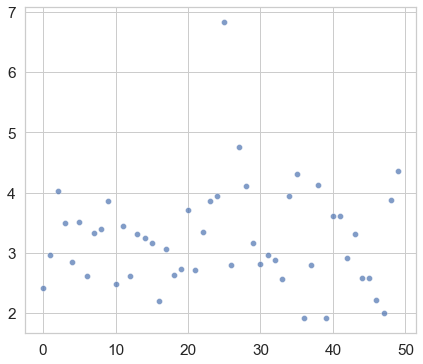

In [22]:
analyze_gini_relations(50)

### Summary
 - At least first 50 rare tags have non-uniform distribution on classes (for both train and test datasets)

Actual train Gini coefs
dart          120.666667
npm           102.666667
.net-core      91.333333
kubernetes     88.666667
vb.net         87.333333
                 ...    
css-tables      0.000000
decrement       0.000000
block           0.000000
openerp         0.000000
include         0.000000
Length: 3959, dtype: float64

Quantiles
              0
0.10   2.191234
0.25   2.587010
0.50   3.177083
0.75   3.866477
0.90   4.516667
1.00  15.333333


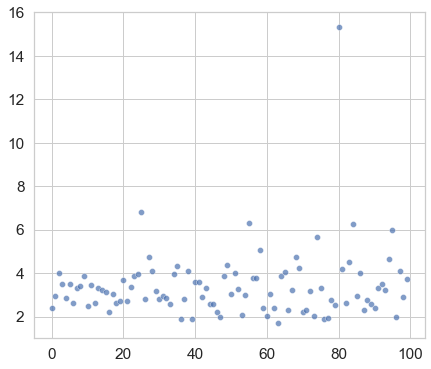

In [23]:
analyze_gini_relations(100)

Actual train Gini coefs
dart          120.666667
npm           102.666667
.net-core      91.333333
kubernetes     88.666667
vb.net         87.333333
                 ...    
css-tables      0.000000
decrement       0.000000
block           0.000000
openerp         0.000000
include         0.000000
Length: 3959, dtype: float64

Quantiles
         0
0.10   1.0
0.25   1.0
0.50   2.0
0.75   3.0
0.90   4.5
1.00  26.0


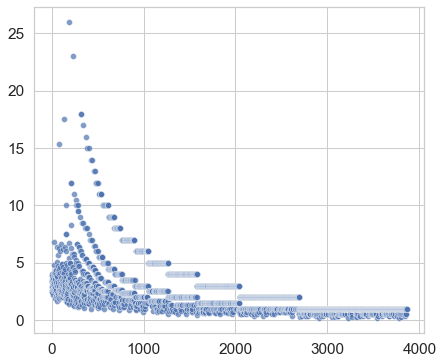

In [24]:
analyze_gini_relations()

In [25]:
interesting_rare_indices = rare_tags['Train'].index[:50]

In [26]:
interesting_rare_indices

Index(['dart', 'npm', '.net-core', 'kubernetes', 'vb.net', 'gradle',
       'ecmascript-6', 'macos', 'winforms', 'docker-compose', 'intellij-idea',
       'unit-testing', 'redux', 'google-chrome', 'jenkins', 'tsql', 'pointers',
       'perl', 'keras', 'vuejs2', 'math', 'github', 'postgresql', 'batch-file',
       'visual-studio-2017', 'apache-spark', 'object', 'numpy', 'variables',
       'class', 'swiftui', 'dockerfile', 'mysqli', 'file', 'rxjs', 'c++17',
       'azure', 'arraylist', 'jupyter-notebook', 'web', 'csv', 'angular-cli',
       'amazon-s3', 'matlab', 'wpf', 'mongodb', 'codeigniter', 'sqlite',
       'swift3', 'random'],
      dtype='object')

## Text processing

### Throw out extra symbols!

In [63]:
def remove_html_tags(text):
    html_detector = re.compile(r'<.*?>')
    return html_detector.sub(r'', text)

def remove_links(text):
    links_remover = re.compile(r'https?://\S+|www\.\S+')
    return links_remover.sub(r'', text)

#split_symbols = '\n| |{|}|\(|\)|\[|\]|\,|\.|\[^e]-[^0-9]|\=|\+|\*|\?'
split_symbols = '[^A-Za-z]'

def preprocess_body(body):
    body = remove_html_tags(body)
    body = remove_links(body)
    body = body.replace('&gt;', '>').replace('&lt;', '<').replace('&le;', '<=').replace('&ge;', '>=')
    splitted = re.split(split_symbols, body)
    result = []
    for part in splitted:
        if len(part.strip()) > 0:
            result.append(part)
    return result

def preprocess_title(title):
    title = remove_links(title)
    splitted = re.split(split_symbols, title)
    result = []
    for part in splitted:
        if len(part.strip()) > 0:
            result.append(part)
    return result

In [64]:
bodies = {}
titles = {}
label_map={'HQ': 0, 'LQ_EDIT': 1, 'LQ_CLOSE': 2}
reverse_label_map={0: 'HQ', 1: 'LQ_EDIT', 2: 'LQ_CLOSE'}

for idx, (dataset_name, dataset) in enumerate(datasets):
    bodies[dataset_name] = {}
    titles[dataset_name] = {}
    for idx, row in dataset.iterrows():
        processed_body = preprocess_body(row['Body'])
        processed_title = preprocess_title(row['Title'])
        if len(processed_body) == 0 or len(processed_title) == 0:
            continue
        bodies[dataset_name][idx] = (processed_body, label_map[row['Y']])
        titles[dataset_name][idx] = (processed_title, label_map[row['Y']])
            

### Text lengths distribution

In [65]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']

Quantiles Train
      Lengths
0.10     29.0
0.25     46.0
0.50     78.0
0.75    133.0
0.99    668.0
1.00   3562.0
Quantiles Test
      Lengths
0.10    30.00
0.25    46.00
0.50    79.00
0.75   134.00
0.99   688.02
1.00  4826.00


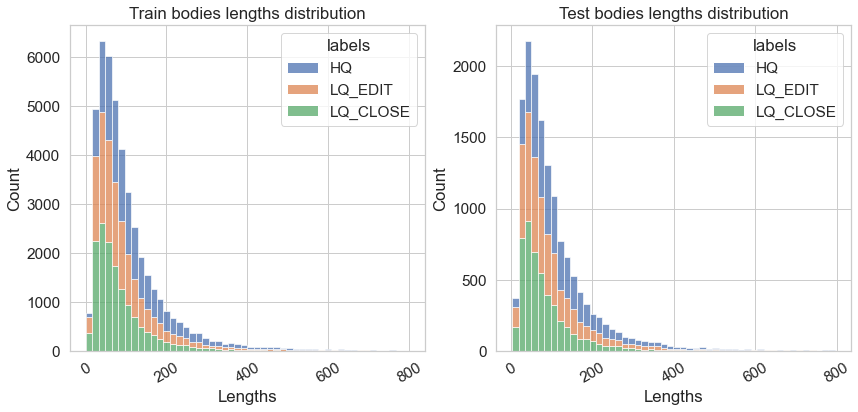

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
target_dict = bodies

for idx, (dataset_name, dataset) in enumerate(datasets):
    lengths = []
    labels = []
    for key, value in target_dict[dataset_name].items():
        lengths.append(len(value[0]))
        labels.append(reverse_label_map[value[1]])
    df = pd.DataFrame(data={'Lengths': lengths, 'labels': labels})
    print(f'Quantiles {dataset_name}')
    print(df.quantile([0.1, 0.25, 0.5, 0.75, 0.99, 1]))
    df = df[df['Lengths'] < 800]
    sns.histplot(data=df, x='Lengths', bins=50, multiple='stack', hue='labels', ax=axes[idx],
                palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} bodies lengths distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)

Quantiles
      Lengths
0.10      5.0
0.25      6.0
0.50      9.0
0.75     11.0
0.99     23.0
1.00     35.0
Quantiles
      Lengths
0.10      5.0
0.25      6.0
0.50      9.0
0.75     11.0
0.99     23.0
1.00     32.0


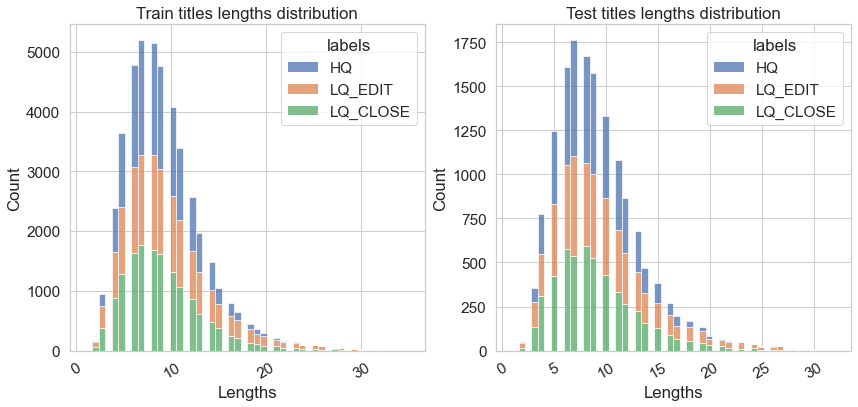

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
target_dict = titles

for idx, (dataset_name, dataset) in enumerate(datasets):
    lengths = []
    labels = []
    for key, value in target_dict[dataset_name].items():
        lengths.append(len(value[0]))
        labels.append(reverse_label_map[value[1]])
    df = pd.DataFrame(data={'Lengths': lengths, 'labels': labels})
    print('Quantiles')
    print(df.quantile([0.1, 0.25, 0.5, 0.75, 0.99, 1]))
    df = df[df['Lengths'] < 40]
    sns.histplot(data=df, x='Lengths', bins=50, multiple='stack', hue='labels', ax=axes[idx],
                palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} titles lengths distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)

# Let's find answers

**Through AI and classical NLP approaches**

## Charts plotter

**Common functionality to evaluate results of algorithm**

In [68]:
def plot_metrics(metrics_list, titles, metric_to_compare, drop_last=False):
    metrics_count = len(metrics_list)
    fig, axes = plt.subplots(metrics_count, 1, figsize=(10, 6*metrics_count))
    for idx, metrics in enumerate(metrics_list):
        reduced_dict = {}
        for stage_name, stage in metrics.items():
            reduced_dict[stage_name] = stage[metric_to_compare]
        metrics_df = pd.DataFrame.from_dict(reduced_dict)
        if drop_last:
            metrics_df.drop(df.tail(n).index,inplace=True)
        sns.lineplot(data=metrics_df, ax=axes[idx])
        axes[idx].set_title(titles[idx])

# XGBoost/RandomForest/kNN with Bag-of-words

In [168]:
def get_tags_dataframe(dataset, keys, tags_index):
    tags_lines = []
    tags_index_set = set(tags_index.values)
    for idx in keys:
        local_tags_str = dataset['Tags'].iloc[idx]
        local_tags = set(local_tags_str[1:-1].split('><'))
        tags_line = np.zeros(len(tags_index), dtype=np.float32)
        for tag_idx, tag in enumerate(tags_index.values):
            tags_line[tag_idx] = 1. if tag in local_tags else 0.
        tags_lines.append(tags_line)
    return pd.DataFrame(data=tags_lines, columns=tags_index.values)
    
def get_time_column(dataset, keys, time_rough_mean, time_mean, time_std):
    time_lines = []
    for idx in keys:
        item = dataset['CreationDate'].iloc[idx].value
        item -= time_rough_mean
        item -= time_mean
        item /= time_std
        time_lines.append([item])
    return pd.DataFrame(time_lines, columns=['Time'])

# TODO analyse correlations of rare words with labels
# todo use insights from Time EDA
def prepare_data_pandas(dataset, titles, bodies, good_tags_index, interesting_rare_indices, precomputed=None):
    titles = collections.OrderedDict(sorted(titles.items()))
    bodies = collections.OrderedDict(sorted(bodies.items()))
    if not precomputed:
        precomputed = {}
        is_train = True
    else:
        is_train = False
    if is_train:
        time_values = []
        for idx in bodies.keys():
            item = dataset['CreationDate'].iloc[idx].value
            time_values.append(item)
        time_rough_mean = sum(time_values) // len(time_values)
        precomputed['time_rough_mean'] = time_rough_mean
        for idx in range(len(time_values)):
            time_values[idx] -= time_rough_mean
        numpy_time_values = np.array(time_values, dtype=np.single)
        precomputed['time_mean'] = numpy_time_values.mean()
        precomputed['time_std'] = np.std(numpy_time_values)
        
    time_rough_mean = precomputed['time_rough_mean']
    time_mean = precomputed['time_mean']
    time_std = precomputed['time_std']
    if is_train:
        vectorizer_titles = CountVectorizer(min_df=0.005)
        titles_list = [' '.join(title_line[0]) for title_line in titles.values()]
        X_titles = vectorizer_titles.fit_transform(titles_list)
        title_columns = ['t_'+name for name in vectorizer_titles.get_feature_names_out()]
        X_titles_df = pd.DataFrame(X_titles.toarray(), columns=title_columns)
        vectorizer_bodies = CountVectorizer(min_df=0.005)
        bodies_list = [' '.join(body_line[0]) for body_line in bodies.values()]
        X_bodies = vectorizer_bodies.fit_transform(bodies_list)
        body_columns = ['b_'+name for name in vectorizer_bodies.get_feature_names_out()]
        X_bodies_df = pd.DataFrame(X_bodies.toarray(), columns=body_columns)
        precomputed['vectorizer_titles'] = vectorizer_titles
        precomputed['vectorizer_bodies'] = vectorizer_bodies
    else:
        vectorizer_titles = precomputed['vectorizer_titles']
        titles_list = [' '.join(title_line[0]) for title_line in titles.values()]
        X_titles = vectorizer_titles.transform(titles_list)
        title_columns = ['t_'+name for name in vectorizer_titles.get_feature_names_out()]
        X_titles_df = pd.DataFrame(X_titles.toarray(), columns=title_columns)
        vectorizer_bodies = precomputed['vectorizer_bodies']
        bodies_list = [' '.join(body_line[0]) for body_line in bodies.values()]
        X_bodies = vectorizer_bodies.transform(bodies_list)
        body_columns = ['b_'+name for name in vectorizer_bodies.get_feature_names_out()]
        X_bodies_df = pd.DataFrame(X_bodies.toarray(), columns=body_columns)
    good_tags_df = get_tags_dataframe(dataset, titles.keys(), good_tags_index)
    rare_tags_df = get_tags_dataframe(dataset, titles.keys(), interesting_rare_indices)
    time_df = get_time_column(dataset, titles.keys(), time_rough_mean, time_mean, time_std)
    data = X_titles_df.join(X_bodies_df).join(good_tags_df).join(rare_tags_df).join(time_df)
    
    labels_lines = []
    for idx, sample in titles.items():
        item = sample[1]
        labels_lines.append([item])
    labels = pd.DataFrame(labels_lines, columns=['Label'])
    return data, labels, precomputed


In [169]:
train_bow_data, train_bow_labels, bow_precomputed = prepare_data_pandas(train_data, titles['Train'], bodies['Train'], good_tags_index, interesting_rare_indices)

In [170]:
test_bow_data, test_bow_labels, _ = prepare_data_pandas(valid_data, titles['Test'], bodies['Test'], good_tags_index, interesting_rare_indices, precomputed=bow_precomputed)

## Train ML with BOW

## Torch, how are you?

In [34]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70
  - CuDNN 7.6.5
  - Magma 2.5.2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=10.2, CUDNN_VERSION=7.6.5, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fopenmp -DNDEBUG -DUSE_KINETO -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -DEDGE_PROFILER_USE_KINETO -O2 -fPI

In [35]:
torch.backends.cudnn.is_available()

True

In [36]:
torch.backends.mkldnn.is_available()

True

In [37]:
if torch.cuda.is_available():
    print(torch.cuda.device_count())

1


## Words converter for NN

In [38]:
def get_empty_word(shape, dtype, device):
    return torch.zeros(shape, dtype=dtype, device=device)

def fill_text_data(sentence_tensor, text, limit, embeddings, empty_word, dtype, device):    
    words_added = 0
    word_idx = 0
    while words_added < limit:
        if word_idx >= len(text):
            break
        word = text[word_idx]
        word_idx += 1
        if word in embeddings:
            embedding = embeddings[word]
        else:
            continue
        sentence_tensor.append(torch.tensor(embedding, dtype=dtype, device=device))
        words_added += 1
    extra_limit = limit - words_added
    for word_idx in range(extra_limit):
        sentence_tensor.append(empty_word)

def get_sentence_tensor(title, body, embeddings, empty_word, title_size, body_size, dtype, device):
    sentence_tensor = []
    fill_text_data(sentence_tensor, title, title_size, embeddings, empty_word, dtype, device)
    fill_text_data(sentence_tensor, body, body_size, embeddings, empty_word, dtype, device)
    return torch.stack(sentence_tensor, dim=0).to(device=device)

def find_sentence_statistics(corpus, embeddings):
    lengths = []
    for item in corpus.values():
        sentence = item[0]
        words_counter = 0
        for word in sentence:
            if word in embeddings:
                words_counter += 1
        lengths.append(words_counter)
    return max(lengths), sum(lengths) / len(lengths)

def get_tags_tensor(dataset, idx, tags_list, dtype, device):
    local_tags_str = dataset['Tags'].iloc[idx]
    local_tags = set(local_tags_str[1:-1].split('><'))
    tensor_line = np.zeros(len(tags_list), dtype=np.float32)
    for tag_idx, tag in enumerate(tags_list):
        tensor_line[tag_idx] = 1. if tag in local_tags else 0.
    return torch.tensor(tensor_line, dtype=dtype, device=device)
    
def get_time_tensor(dataset, idx, dtype, device, time_rough_mean, time_mean, time_std):
    item = dataset['CreationDate'].iloc[idx].value
    item -= time_rough_mean
    item -= time_mean
    item /= time_std
    return torch.tensor([item], dtype=dtype, device=device)

# sentences 
#   label_words
#   body_words
def prepare_data_tensors(dataset, titles, bodies, dtype, device, embeddings, good_tags_index, interesting_rare_indices, number_body_words_to_add, number_title_words_to_add, forced_limits=None):
    with torch.no_grad():
        titles = collections.OrderedDict(sorted(titles.items()))
        bodies = collections.OrderedDict(sorted(bodies.items()))
        tags_list = list(set.union(set(good_tags_index), set(interesting_rare_indices)))
        torch_data_list = []
        torch_labels_list = []
        extra_datas = []
        empty_word = get_empty_word(embeddings['car'].shape, dtype, device)
        title_max_length, title_avg_length = find_sentence_statistics(titles, embeddings)
        logger.info(f'Title max length: {title_max_length}, Title avg length: {title_avg_length}')
        body_max_length, body_avg_length = find_sentence_statistics(bodies, embeddings)
        logger.info(f'Body max length: {body_max_length}, Body avg length: {body_avg_length}')
        if not forced_limits:
            title_size = min(number_title_words_to_add, title_max_length)
            body_size = min(number_body_words_to_add, body_max_length)
        else:
            title_size = forced_limits['title_size']
            body_size = forced_limits['body_size']
        
        if not forced_limits:
            time_values = []
            for idx in bodies.keys():
                item = dataset['CreationDate'].iloc[idx].value
                time_values.append(item)
            time_rough_mean = sum(time_values) // len(time_values)
            for idx in range(len(time_values)):
                time_values[idx] -= time_rough_mean
            numpy_time_values = np.array(time_values, dtype=np.single)
            time_mean = numpy_time_values.mean()
            time_std = np.std(numpy_time_values)
        else:
            time_rough_mean = forced_limits['time_rough_mean']
            time_mean = forced_limits['time_mean']
            time_std = forced_limits['time_std']
        
        for idx in bodies.keys():
            sentence_tensor = get_sentence_tensor(titles[idx][0], bodies[idx][0], embeddings, empty_word, title_size, body_size, dtype, device)
            tags_tensor = get_tags_tensor(dataset, idx, tags_list, dtype, device)
            time_tensor = get_time_tensor(dataset, idx, dtype, device, time_rough_mean, time_mean, time_std)
            extra_data = torch.cat([tags_tensor, time_tensor])
            extra_datas.append(extra_data)
            torch_data_list.append(sentence_tensor)
            torch_labels_list.append(bodies[idx][1])
        data = torch.stack(torch_data_list, dim=0).to(device=device)
        extra = torch.stack(extra_datas, dim=0).to(device=device)
        labels = torch.tensor(torch_labels_list, dtype=torch.long, device=device)
        return data, extra, labels, title_size, body_size, time_rough_mean, time_mean, time_std

# Bidirectional RNN Model with FC/XGBoost/RandomForest/kNN head

**Let's call it RNNML!**

In [39]:
import time

class RNNMLModel(nn.Module):
    def __init__(self, embeddings, compute_device, *, title_size, body_size, fc_size1, fc_size2, hidden_dim, embedding_dim, extra_size, dtype):
        super().__init__()
        self.dtype = dtype
        self.hidden_dim = hidden_dim
        self.embeddings = embeddings
        self.compute_device = compute_device
        self.embedding_dim = embedding_dim
        self.title_size = title_size
        self.body_size = body_size
        self.extra_size = extra_size
        self.fc_size1 = fc_size1
        self.fc_size2 = fc_size2
        self.classifier = None
        self.lstm_forward_title = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.lstm_backward_title = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.lstm_forward_body = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.lstm_backward_body = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        
        self.input_size = self.hidden_dim * 4 + self.extra_size
        self.lstmout_scale_factor = 1
        self.lstmout_estimation = torch.full((1, self.input_size), 0, dtype=self.dtype, device=self.compute_device)
        self.lstmout_std = torch.full((1, self.input_size,), 1, dtype=self.dtype, device=self.compute_device)
        
        self.fc1_1 = nn.Linear(self.input_size, self.fc_size1)
        self.fc1_2 = nn.Linear(self.input_size, self.fc_size1)
        self.fc1_3 = nn.Linear(self.input_size, self.fc_size1)
        self.prelu1_1 = nn.PReLU()
        self.prelu1_2 = nn.PReLU()
        self.prelu1_3 = nn.PReLU()
        self.batchnorm1_1 = nn.BatchNorm1d(self.fc_size1)
        self.batchnorm1_2 = nn.BatchNorm1d(self.fc_size1)
        self.batchnorm1_3 = nn.BatchNorm1d(self.fc_size1)
        self.fc2_1 = nn.Linear(self.fc_size1, self.fc_size2)
        self.fc2_2 = nn.Linear(self.fc_size1, self.fc_size2)
        self.fc2_3 = nn.Linear(self.fc_size1, self.fc_size2)
        self.prelu2_1 = nn.PReLU()
        self.prelu2_2 = nn.PReLU()
        self.prelu2_3 = nn.PReLU()
        self.batchnorm2_1 = nn.BatchNorm1d(self.fc_size2)
        self.batchnorm2_2 = nn.BatchNorm1d(self.fc_size2)
        self.batchnorm2_3 = nn.BatchNorm1d(self.fc_size2)
        self.fc3_1 = nn.Linear(self.fc_size2, 1)
        self.fc3_2 = nn.Linear(self.fc_size2, 1)
        self.fc3_3 = nn.Linear(self.fc_size2, 1)
        self.softmax = nn.Softmax(dim=1)

    def _get_hidden_state_for_words(self, lstm_cell, data, iterable_idx, hx_init, cx_init):
        hx = hx_init.detach().clone()
        cx = cx_init.detach().clone()
        hx_copies = [hx]
        for idx in iterable_idx:
            subdata = data[idx]
            hx, cx = lstm_cell(subdata, (hx, cx))
            hx_copies.append(hx)
        return torch.stack(hx_copies, dim=2)
    
    def _eval_part_of_hidden(self, data, hx_init, cx_init, iterable_idx, fwd_lstm_cell, bkwd_lstm_cell):
        forward_pass = self._get_hidden_state_for_words(fwd_lstm_cell, data, iterable_idx, hx_init, cx_init)
        forward_pooled = self.maxpool(forward_pass).view(-1, self.hidden_dim)
        backward_pass = self._get_hidden_state_for_words(bkwd_lstm_cell, data, reversed(iterable_idx), hx_init, cx_init)
        backward_pooled = self.maxpool(backward_pass).view(-1, self.hidden_dim)
        concat_pass = torch.cat([forward_pooled, backward_pooled], dim=1)
        return concat_pass
    
    def _eval_hidden(self, data, hx_init, cx_init):
        title_iterable_id = range(self.title_size)
        title_pass = self._eval_part_of_hidden(data, hx_init, cx_init, title_iterable_id, self.lstm_forward_title, self.lstm_backward_title)
        body_start_idx = self.title_size
        body_iterable_id = range(body_start_idx, body_start_idx + self.body_size)
        body_pass = self._eval_part_of_hidden(data, hx_init, cx_init, body_iterable_id, self.lstm_forward_body, self.lstm_backward_body)
        concat_pass = torch.cat([title_pass, body_pass], dim=1)
        return concat_pass

    def _lstm_part_forward(self, data):
        data = torch.transpose(data, 0, 1)
        hx_init = torch.zeros(data.shape[1], self.hidden_dim, dtype=self.dtype, device=self.compute_device)
        cx_init = torch.zeros(data.shape[1], self.hidden_dim, dtype=self.dtype, device=self.compute_device)
        hidden_result = self._eval_hidden(data, hx_init, cx_init)
        return hidden_result
    
    def prehead_forward(self, data, extra):
        hidden_result = self._lstm_part_forward(data)
        lstm_res = (hidden_result - self.lstmout_estimation) / self.lstmout_std * self.lstmout_scale_factor
        return torch.cat([lstm_res, extra], dim=1)
    
    # X - [batch_size, words_num, embed_dim]
    def forward(self, data, extra, mode):
        prehead_result = self.prehead_forward(data, extra)
        if mode == 'nn':
            fc1_1_res = self.fc1_1(prehead_result)
            fc1_2_res = self.fc1_2(prehead_result)
            fc1_3_res = self.fc1_3(prehead_result)

            prelu1_1_res = self.prelu1_1(fc1_1_res)
            prelu1_2_res = self.prelu1_2(fc1_2_res)
            prelu1_3_res = self.prelu1_3(fc1_3_res)

            normalized1_1_res = self.batchnorm1_1(prelu1_1_res)
            normalized1_2_res = self.batchnorm1_2(prelu1_2_res)
            normalized1_3_res = self.batchnorm1_3(prelu1_3_res)
            
            fc2_1_res = self.fc2_1(normalized1_1_res)
            fc2_2_res = self.fc2_2(normalized1_2_res)
            fc2_3_res = self.fc2_3(normalized1_3_res)
            
            prelu2_1_res = self.prelu2_1(fc2_1_res)
            prelu2_2_res = self.prelu2_2(fc2_2_res)
            prelu2_3_res = self.prelu2_3(fc2_3_res)
            
            normalized2_1_res = self.batchnorm2_1(prelu2_1_res)
            normalized2_2_res = self.batchnorm2_2(prelu2_2_res)
            normalized2_3_res = self.batchnorm2_3(prelu2_3_res)
            
            fc3_1_res = self.fc3_1(normalized2_1_res)
            fc3_2_res = self.fc3_2(normalized2_2_res)
            fc3_3_res = self.fc3_3(normalized2_3_res)
            
            head_res = torch.cat([fc3_1_res, fc3_2_res, fc3_3_res], 1)
            softmax_res = self.softmax(head_res)
            return softmax_res
        elif mode == 'ml':
            numpy_prehead_res = prehead_result.detach().cpu().numpy()
            probs = self.classifier.predict_proba(numpy_prehead_res)
            res = torch.tensor(probs, dtype=self.dtype, device=self.compute_device)
            return res
        else:
            raise Exception('forward: Wrong mode.')
        
    def recalculate_lstmout_statistics(self, data, extra):
        batch_size = 1024
        train_indices = list(BatchSampler(RandomSampler(range(data.shape[0])), 
                                         batch_size=batch_size, drop_last=False))
        x_train_list = []
        for batch_idx, batch_indices in enumerate(train_indices):
            batch_data = data[batch_indices]
            batch_extra = extra[batch_indices]
            x_train_list.append(self._lstm_part_forward(batch_data).detach())
        x_train = torch.cat(x_train_list)
        self.lstmout_estimation = x_train.mean(dim=0).unsqueeze(0)
        self.lstmout_std = torch.std(x_train, dim=0, keepdim=True)
        self.lstmout_std = self.lstmout_std.where(torch.abs(self.lstmout_std) >= 1e-4, torch.tensor(1, dtype=self.dtype))
#         print('STATISTICS', self.lstmout_estimation, self.lstmout_std)
        del x_train_list
        gc.collect()
        
    def _prepare_data_for_ml(self, data, extra, labels, test_data, test_extra, test_labels):
        with torch.no_grad():
            batch_size = 1024
            train_indices = list(BatchSampler(RandomSampler(range(data.shape[0])), 
                                             batch_size=batch_size, drop_last=False))
            test_indices = list(BatchSampler(RandomSampler(range(test_data.shape[0])), 
                                             batch_size=batch_size, drop_last=False))
            numpy_x_train_list = []
            numpy_y_train_list = []
            numpy_x_test_list = []
            numpy_y_test_list = []
            for batch_idx, batch_indices in enumerate(train_indices):
                batch_data = data[batch_indices].detach()
                batch_extra = extra[batch_indices].detach()
                numpy_x_train_list.append(self.prehead_forward(batch_data, batch_extra).detach().cpu().numpy())
                numpy_y_train_list.append(labels[batch_indices].detach().cpu().numpy())
                del batch_data, batch_extra
                gc.collect()
                torch.cuda.empty_cache()
            for batch_idx, batch_indices in enumerate(test_indices):
                batch_data = test_data[batch_indices].detach()
                batch_extra = test_extra[batch_indices].detach()
                numpy_x_test_list.append(self.prehead_forward(batch_data, batch_extra).detach().cpu().numpy())
                numpy_y_test_list.append(test_labels[batch_indices].detach().cpu().numpy())
                del batch_data, batch_extra
                gc.collect()
                torch.cuda.empty_cache()

            numpy_x_train = np.concatenate(numpy_x_train_list)
            numpy_y_train = np.concatenate(numpy_y_train_list)
            numpy_x_test = np.concatenate(numpy_x_test_list)
            numpy_y_test = np.concatenate(numpy_y_test_list)
            del numpy_x_train_list, numpy_x_test_list, numpy_y_train_list, numpy_y_test_list
            gc.collect()
            return numpy_x_train, numpy_y_train, numpy_x_test, numpy_y_test
        
    def fit_ml_head(self, data, extra, labels, test_data, test_extra, test_labels, objective):
        numpy_x_train, numpy_y_train, numpy_x_test, numpy_y_test = self._prepare_data_for_ml(data, extra, labels, test_data, test_extra, test_labels)
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, numpy_x_train, numpy_y_train, numpy_x_test, numpy_y_test), n_trials=3, n_jobs=1)
        logger.info(f'ML part fitting. Best score: {study.best_value}, best params: {study.best_params}')
        classifier_classname = study.best_params['classifier']
        if classifier_classname == 'RandomForest':
            classifier_class = RandomForestClassifier
        elif classifier_classname == 'kNN':
            classifier_class = KNeighborsClassifier
        elif classifier_classname == 'XGBoost':
            classifier_class = xgb.XGBClassifier
        else:
            raise Exception('fit_ml_head: Unknows classifier name.')
        alg_params = study.best_params.copy()
        del alg_params['classifier']
#         self.classifier = make_pipeline(StandardScaler(), classifier_class(**alg_params))
        self.classifier = classifier_class(**alg_params)

        self.classifier.fit(numpy_x_train, numpy_y_train)
        return study


## Train function definition

In [46]:
def rnnml_evaluate(data, extra, labels, model, criterion, compute_device, batch_indices, metrics, metrics_stage, mode):
    with torch.no_grad():
        accuracy_torch = Accuracy(num_classes=3, average='macro')
        f1score_torch = F1Score(num_classes=3, average='macro')
        confmat_torch = ConfusionMatrix(num_classes=3)
        local_conf_matrices = []
        local_loss = []
        local_metrics_accuracy = []
        local_metrics_f1score = []
        for batch_idx, batch_indices in enumerate(batch_indices):
            batch_data = data[batch_indices].to(compute_device).detach()
            batch_extra = extra[batch_indices].to(compute_device).detach()
            batch_labels = labels[batch_indices].to(compute_device).detach()
            predicted = model.forward(batch_data, batch_extra, mode).detach()
            loss = criterion(predicted, batch_labels).detach()
            local_loss.append(loss.item())
            local_metrics_accuracy.append(accuracy_torch(predicted, batch_labels).item())
            local_metrics_f1score.append(f1score_torch(predicted, batch_labels).item())
            local_conf_matrices.append(confmat_torch(predicted, batch_labels).detach().cpu().numpy())
            del batch_data, batch_extra, batch_labels, predicted, loss
            gc.collect()
            torch.cuda.empty_cache()
        result_confmat = sum(local_conf_matrices)
        metrics[metrics_stage]['loss'].append(sum(local_loss) / len(local_loss))
#         print('@@ CHECK', metrics[metrics_stage]['loss'][-1], sum(local_loss), len(local_loss))
        metrics[metrics_stage]['accuracy'].append(sum(local_metrics_accuracy) / len(local_metrics_accuracy))
        metrics[metrics_stage]['f1score'].append(sum(local_metrics_f1score) / len(local_metrics_f1score))
        metrics[metrics_stage]['confmat'].append(result_confmat.flatten())
    
def rnnml_get_latest_metrics(metrics):
    latest_metrics = {}
    for stage in ('train_nn', 'test_nn', 'train_ml', 'test_ml'):
        latest_metrics[stage] = {}
        for key, value in metrics[stage].items():
            try:
                latest_metrics[stage][key] = f'{metrics[stage][key][-1]:.3f}'
            except TypeError as e:
                latest_metrics[stage][key] = f'{str(metrics[stage][key][-1])}'
    return latest_metrics

# todo Tune grad norm factor, probably use different optimizers for RNN/notRNN parts
# todo use insights from Time EDA
def rnnml_train(torch_train_data, torch_train_extra, torch_train_labels, 
          torch_test_data, torch_test_extra, torch_test_labels, 
          model_class, embeddings, epoch_count, batch_size, device, compute_device, dtype, 
          ml_fitting_freq, **kwargs):
    model = model_class(embeddings, compute_device, **kwargs, dtype=dtype).to(compute_device)
    model.recalculate_lstmout_statistics(torch_train_data, torch_train_extra)
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    scheduler = ExponentialLR(optimizer, gamma=0.85, verbose=True)
    criterion = nn.CrossEntropyLoss()
    logger.info('Model was created.')
    metrics = {
        'train_nn' : {
            'loss' : [],
            'confmat' : [],
            'accuracy' : [],
            'f1score' : []
        },
        'test_nn' : {
            'loss' : [],
            'confmat' : [],
            'accuracy' : [],
            'f1score' : []
        }
        ,
        'train_ml' : {
            'loss' : [],
            'confmat' : [],
            'accuracy' : [],
            'f1score' : []
        },
        'test_ml' : {
            'loss' : [],
            'confmat' : [],
            'accuracy' : [],
            'f1score' : []
        }
    }
    studies = []
    gc.collect()
    torch.cuda.empty_cache()
    
    def objective(trial, X, y, X_test, y_test):
        classifier_str = trial.suggest_categorical('classifier', ['RandomForest', 'XGBoost', 'kNN'])
        if classifier_str == 'RandomForest':
            n_estimators = trial.suggest_int('n_estimators', 16, 64)
            max_depth = trial.suggest_int('max_depth', 2, 8)
            alg = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        elif classifier_str == 'kNN':
            n_neighbors = trial.suggest_int('n_neighbors', 2, 128)
            algorithm = 'brute'
            alg = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=algorithm)
        elif classifier_str == 'XGBoost':
            n_estimators = trial.suggest_int('n_estimators', 8, 64)
            max_depth = trial.suggest_int('max_depth', 2, 8)
            alg = xgb.XGBClassifier(objective='multi:softprob', learning_rate=0.1, 
                                    n_estimators=n_estimators, max_depth=max_depth, 
                                    n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
        else:
            raise Exception('Optuna usage: Unknows classifier name.')
#         print('run', classifier_str)
#         alg = make_pipeline(StandardScaler(), alg)
        alg.fit(X, y)
        test_probs = alg.predict_proba(X_test)
        score = f1_score(y_test, np.argmax(test_probs, axis=1), average='macro')
        gc.collect()
        return score

    for epoch in range(epoch_count):
        logger.info(f'Epoch {epoch}/{epoch_count-1} started.')
#         print('#1')
        # Train loop
        perm_indices = list(BatchSampler(RandomSampler(range(torch_train_data.shape[0])), 
                                         batch_size=batch_size, drop_last=False))
        for batch_idx, batch_indices in enumerate(perm_indices):
            batch_data = torch_train_data[batch_indices].to(compute_device)
            batch_extra = torch_train_extra[batch_indices].to(compute_device)
            batch_labels = torch_train_labels[batch_indices].to(compute_device)
            optimizer.zero_grad()
            predicted = model.forward(batch_data, batch_extra, 'nn')
            loss = criterion(predicted, batch_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
#             with torch.no_grad():
#                 for n, p in model.named_parameters():
#                     print(f'## Layer {n}')
#                     param_norm = p.detach().data.norm(2)
#                     grad_norm = p.grad.detach().data.norm(2)
#                     print(f'ParamNorm {param_norm.item()}, GradNorm {grad_norm.item()}')
#                     print('BEFORE GRAD', p.grad.view(-1).mean().item(), torch.std(p.grad.view(-1)).item())
#                     print('BEFORE W', p.view(-1).mean().item(), torch.std(p.view(-1)).item())
#                     if np.isnan(torch.std(p.grad.view(-1)).item()):
#                         print(p.grad)
#                     print(p.grad)
#                     print(p)
#                     if p.grad.view(-1).size()[0] > 1:
#                         p.grad -= p.grad.view(-1).mean().item() #.div_(torch.norm(p, dim=1, keepdim=True))
#                         std = torch.std(p.grad.view(-1)).item()
#                         if std >= 1e-4:
#                             p.grad /= std
# #                     grad_norm = p.grad.detach().data.norm(2)
                    
#                     if p.view(-1).size()[0] > 1:
#                         p -= p.view(-1).mean().item() #.div_(torch.norm(p, dim=1, keepdim=True))
#                         std = torch.std(p.view(-1)).item()
#                         if std >= 1e-4:
#                             p /= std
#                     print('AFTER GRAD', p.grad.view(-1).mean().item(), torch.std(p.grad.view(-1)).item())
#                     print('AFTER W', p.view(-1).mean().item(), torch.std(p.view(-1)).item())
#                     if np.isnan(torch.std(p.grad.view(-1)).item()):
#                         print(p.grad)
#                         print(p.grad)
#                         print(p)
#                     param_norm = p.detach().data.norm(2)
#                     print(f'Normalized: ParamNorm {param_norm.item()}, GradNorm {grad_norm.item()}')
            optimizer.step()
            del batch_data, batch_labels, batch_extra, predicted, loss
            gc.collect()
            torch.cuda.empty_cache()
        scheduler.step()
        
        gc.collect()
        torch.cuda.empty_cache()
        model.recalculate_lstmout_statistics(torch_train_data, torch_train_extra)
        
#         print('##### Weights #####')
#         for idx, cell in enumerate((model.lstm_forward_title, model.lstm_backward_title, model.lstm_forward_body, model.lstm_backward_body)):
#             print(f'# Number {idx}')
#             print(cell.weight_ih)
#             print(cell.weight_hh)
#             print(cell.bias_ih)
#             print(cell.bias_hh)
#         print('##### ####### #####')
        
#         self.lstm_forward_title = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
#         self.lstm_backward_title = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
#         self.lstm_forward_body = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
#         self.lstm_backward_body = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        
#         print('#2')
        if epoch % ml_fitting_freq == 0 or epoch + 1 == epoch_count:
            study = model.fit_ml_head(torch_train_data, torch_train_extra, torch_train_labels, 
                torch_test_data, torch_test_extra, torch_test_labels, objective)
            studies.append(study)
#         print('#3')
        gc.collect()
        torch.cuda.empty_cache()
        
        # Test on test data
        test_batch_size = 4096
        test_perm_indices = list(BatchSampler(RandomSampler(range(torch_test_data.shape[0])), 
                                         batch_size=test_batch_size, drop_last=True))
        rnnml_evaluate(torch_test_data, torch_test_extra, torch_test_labels, 
                 model, criterion, compute_device, test_perm_indices, metrics, 'test_nn', 'nn')
#         print('#4')
        # Test on train data
        train_batch_size = 4096
        train_perm_indices = list(BatchSampler(RandomSampler(range(torch_train_data.shape[0])), 
                                         batch_size=train_batch_size, drop_last=True))
        rnnml_evaluate(torch_train_data, torch_train_extra, torch_train_labels, 
                 model, criterion, compute_device, train_perm_indices, metrics, 'train_nn', 'nn')
#         print('#5')
        gc.collect()
        torch.cuda.empty_cache()
        
        if epoch % ml_fitting_freq == 0 or epoch + 1 == epoch_count:
            # Test on test data
            test_batch_size = 4096
            test_perm_indices = list(BatchSampler(RandomSampler(range(torch_test_data.shape[0])), 
                                             batch_size=test_batch_size, drop_last=True))
            rnnml_evaluate(torch_test_data, torch_test_extra, torch_test_labels, 
                     model, criterion, compute_device, test_perm_indices, metrics, 'test_ml', 'ml')
#             print('#6')
            # Test on train data
            train_batch_size = 4096
            train_perm_indices = list(BatchSampler(RandomSampler(range(torch_train_data.shape[0])), 
                                             batch_size=train_batch_size, drop_last=True))
            rnnml_evaluate(torch_train_data, torch_train_extra, torch_train_labels, 
                     model, criterion, compute_device, train_perm_indices, metrics, 'train_ml', 'ml')
        else:
            for stage in ('test_ml', 'train_ml'):
                for key, value in metrics[stage].items():
                    metrics[stage][key].append(metrics[stage][key][-1])
#         print('#7')
        gc.collect()
        torch.cuda.empty_cache()
        logger.info(f'Epoch {epoch} finished. Metrics: {rnnml_get_latest_metrics(metrics)}.')    
    
    return model, metrics, studies


## Let's train RNNML with GloVe embeddings

In [41]:
rnnml_embeddings = gensim.downloader.load('glove-twitter-100')

In [42]:
rnnml_hidden_dim = 100
rnnml_fc_size1 = 200
rnnml_fc_size2 = 100
rnnml_embedding_dim = 100
rnnml_epoch_count = 50
rnnml_batch_size = 1024
rnnml_extra_size = 126
rnnml_ml_fitting_freq = 5
rnnml_number_body_words_to_add = 90
rnnml_number_title_words_to_add = 15
rnnml_device = torch.device("cpu")
rnnml_compute_device = torch.device("cpu")
rnnml_dtype = torch.float32

In [43]:
rnnml_torch_train_data, rnnml_torch_train_extra, rnnml_torch_train_labels, rnnml_title_size, rnnml_body_size, time_rough_mean, time_mean, time_std = prepare_data_tensors(train_data, titles['Train'], bodies['Train'], rnnml_dtype, rnnml_device, rnnml_embeddings, good_tags_index, interesting_rare_indices, rnnml_number_body_words_to_add, rnnml_number_title_words_to_add)
logger.info('Train data was prepared.')

INFO:nlp:Title max length: 32, Title avg length: 6.935862390826055
INFO:nlp:Body max length: 2968, Body avg length: 87.12058581683223
INFO:nlp:Train data was prepared.


In [44]:
rnnml_torch_test_data, rnnml_torch_test_extra, rnnml_torch_test_labels, _, _, _, _, _ = prepare_data_tensors(valid_data, titles['Test'], bodies['Test'], rnnml_dtype, rnnml_device, rnnml_embeddings, good_tags_index, interesting_rare_indices, rnnml_number_body_words_to_add, rnnml_number_title_words_to_add, forced_limits={'title_size' : rnnml_title_size, 'body_size' : rnnml_body_size, 'time_mean' : time_mean, 'time_std' : time_std, 'time_rough_mean' : time_rough_mean})
logger.info('Test data was prepared.')

INFO:nlp:Title max length: 31, Title avg length: 6.925128341889459
INFO:nlp:Body max length: 4427, Body avg length: 88.17801186745783
INFO:nlp:Test data was prepared.


In [47]:
rnnml_model, rnnml_metrics, rnnml_studies = rnnml_train(rnnml_torch_train_data, rnnml_torch_train_extra, rnnml_torch_train_labels, rnnml_torch_test_data, rnnml_torch_test_extra,
      rnnml_torch_test_labels, RNNMLModel, rnnml_embeddings, rnnml_epoch_count, rnnml_batch_size, rnnml_device, rnnml_compute_device, rnnml_dtype, rnnml_ml_fitting_freq,
      title_size=rnnml_title_size, body_size=rnnml_body_size, fc_size1=rnnml_fc_size1, fc_size2=rnnml_fc_size2, hidden_dim=rnnml_hidden_dim, 
      embedding_dim=rnnml_embedding_dim, extra_size=rnnml_extra_size)

INFO:nlp:Model was created.


Adjusting learning rate of group 0 to 1.0000e-01.


INFO:nlp:Epoch 0/149 started.


Adjusting learning rate of group 0 to 9.5000e-02.


INFO:nlp:ML part fitting. Best score: 0.5090480850932305, best params: {'classifier': 'RandomForest', 'n_estimators': 25, 'max_depth': 3}
INFO:nlp:Epoch 0 finished. Metrics: {'train_nn': {'loss': '1.024', 'confmat': '[8370 1011 4282 2664 4704 6317 2969 2315 8328]', 'accuracy': '0.523', 'f1score': '0.517'}, 'test_nn': {'loss': '1.026', 'confmat': '[2506  310 1268  830 1407 1873  910  714 2470]', 'accuracy': '0.520', 'f1score': '0.514'}, 'train_ml': {'loss': '1.072', 'confmat': '[9771  812 3031 4199 5036 4452 4618 2763 6278]', 'accuracy': '0.515', 'f1score': '0.505'}, 'test_ml': {'loss': '1.072', 'confmat': '[2917  271  891 1217 1597 1280 1416  873 1826]', 'accuracy': '0.516', 'f1score': '0.508'}}.
INFO:nlp:Epoch 1/149 started.


Adjusting learning rate of group 0 to 9.0250e-02.


INFO:nlp:Epoch 1 finished. Metrics: {'train_nn': {'loss': '1.005', 'confmat': '[10215  1161  2213  3431  6392  3838  4443  3640  5627]', 'accuracy': '0.543', 'f1score': '0.534'}, 'test_nn': {'loss': '1.011', 'confmat': '[3060  347  695 1054 1911 1153 1340 1099 1629]', 'accuracy': '0.537', 'f1score': '0.528'}, 'train_ml': {'loss': '1.072', 'confmat': '[9771  812 3031 4199 5036 4452 4618 2763 6278]', 'accuracy': '0.515', 'f1score': '0.505'}, 'test_ml': {'loss': '1.072', 'confmat': '[2917  271  891 1217 1597 1280 1416  873 1826]', 'accuracy': '0.516', 'f1score': '0.508'}}.
INFO:nlp:Epoch 2/149 started.


Adjusting learning rate of group 0 to 8.5737e-02.


INFO:nlp:Epoch 2 finished. Metrics: {'train_nn': {'loss': '0.992', 'confmat': '[9853 1310 2494 2851 6498 4360 3503 3714 6377]', 'accuracy': '0.555', 'f1score': '0.550'}, 'test_nn': {'loss': '0.994', 'confmat': '[2934  401  757  858 1960 1303 1057 1114 1904]', 'accuracy': '0.553', 'f1score': '0.549'}, 'train_ml': {'loss': '1.072', 'confmat': '[9771  812 3031 4199 5036 4452 4618 2763 6278]', 'accuracy': '0.515', 'f1score': '0.505'}, 'test_ml': {'loss': '1.072', 'confmat': '[2917  271  891 1217 1597 1280 1416  873 1826]', 'accuracy': '0.516', 'f1score': '0.508'}}.
INFO:nlp:Epoch 3/149 started.


Adjusting learning rate of group 0 to 8.1451e-02.


INFO:nlp:Epoch 3 finished. Metrics: {'train_nn': {'loss': '0.986', 'confmat': '[10630  1525  1500  3282  7582  2760  4252  4760  4669]', 'accuracy': '0.559', 'f1score': '0.544'}, 'test_nn': {'loss': '0.992', 'confmat': '[3163  496  438  975 2270  842 1273 1473 1358]', 'accuracy': '0.553', 'f1score': '0.538'}, 'train_ml': {'loss': '1.072', 'confmat': '[9771  812 3031 4199 5036 4452 4618 2763 6278]', 'accuracy': '0.515', 'f1score': '0.505'}, 'test_ml': {'loss': '1.072', 'confmat': '[2917  271  891 1217 1597 1280 1416  873 1826]', 'accuracy': '0.516', 'f1score': '0.508'}}.
INFO:nlp:Epoch 4/149 started.


Adjusting learning rate of group 0 to 7.7378e-02.


INFO:nlp:Epoch 4 finished. Metrics: {'train_nn': {'loss': '0.976', 'confmat': '[10720  1222  1729  3390  6866  3364  4265  3773  5631]', 'accuracy': '0.567', 'f1score': '0.557'}, 'test_nn': {'loss': '0.990', 'confmat': '[3154  402  537 1062 2034 1014 1348 1137 1600]', 'accuracy': '0.552', 'f1score': '0.542'}, 'train_ml': {'loss': '1.072', 'confmat': '[9771  812 3031 4199 5036 4452 4618 2763 6278]', 'accuracy': '0.515', 'f1score': '0.505'}, 'test_ml': {'loss': '1.072', 'confmat': '[2917  271  891 1217 1597 1280 1416  873 1826]', 'accuracy': '0.516', 'f1score': '0.508'}}.
INFO:nlp:Epoch 5/149 started.


Adjusting learning rate of group 0 to 7.3509e-02.


INFO:nlp:Epoch 5 finished. Metrics: {'train_nn': {'loss': '0.970', 'confmat': '[9196 1582 2917 1949 7847 3827 2633 4617 6392]', 'accuracy': '0.572', 'f1score': '0.571'}, 'test_nn': {'loss': '0.978', 'confmat': '[2741  521  867  594 2317 1176  802 1413 1857]', 'accuracy': '0.562', 'f1score': '0.562'}, 'train_ml': {'loss': '1.072', 'confmat': '[9771  812 3031 4199 5036 4452 4618 2763 6278]', 'accuracy': '0.515', 'f1score': '0.505'}, 'test_ml': {'loss': '1.072', 'confmat': '[2917  271  891 1217 1597 1280 1416  873 1826]', 'accuracy': '0.516', 'f1score': '0.508'}}.
INFO:nlp:Epoch 6/149 started.


Adjusting learning rate of group 0 to 6.9834e-02.


INFO:nlp:Epoch 6 finished. Metrics: {'train_nn': {'loss': '0.948', 'confmat': '[9952 1313 2322 2497 7080 4134 3270 3446 6946]', 'accuracy': '0.586', 'f1score': '0.582'}, 'test_nn': {'loss': '0.968', 'confmat': '[2918  437  745  773 2095 1248 1058 1130 1884]', 'accuracy': '0.561', 'f1score': '0.557'}, 'train_ml': {'loss': '1.072', 'confmat': '[9771  812 3031 4199 5036 4452 4618 2763 6278]', 'accuracy': '0.515', 'f1score': '0.505'}, 'test_ml': {'loss': '1.072', 'confmat': '[2917  271  891 1217 1597 1280 1416  873 1826]', 'accuracy': '0.516', 'f1score': '0.508'}}.
INFO:nlp:Epoch 7/149 started.


Adjusting learning rate of group 0 to 6.6342e-02.


INFO:nlp:Epoch 7 finished. Metrics: {'train_nn': {'loss': '0.919', 'confmat': '[10574  1037  2067  2240  7120  4292  2927  3116  7587]', 'accuracy': '0.617', 'f1score': '0.613'}, 'test_nn': {'loss': '0.951', 'confmat': '[2994  393  695  741 1978 1355  991 1057 2084]', 'accuracy': '0.574', 'f1score': '0.570'}, 'train_ml': {'loss': '1.072', 'confmat': '[9771  812 3031 4199 5036 4452 4618 2763 6278]', 'accuracy': '0.515', 'f1score': '0.505'}, 'test_ml': {'loss': '1.072', 'confmat': '[2917  271  891 1217 1597 1280 1416  873 1826]', 'accuracy': '0.516', 'f1score': '0.508'}}.
INFO:nlp:Epoch 8/149 started.


Adjusting learning rate of group 0 to 6.3025e-02.


INFO:nlp:Epoch 8 finished. Metrics: {'train_nn': {'loss': '0.901', 'confmat': '[10700  1155  1823  1983  8139  3528  2653  3715  7264]', 'accuracy': '0.637', 'f1score': '0.634'}, 'test_nn': {'loss': '0.942', 'confmat': '[3048  420  625  651 2276 1171  928 1258 1911]', 'accuracy': '0.589', 'f1score': '0.585'}, 'train_ml': {'loss': '1.072', 'confmat': '[9771  812 3031 4199 5036 4452 4618 2763 6278]', 'accuracy': '0.515', 'f1score': '0.505'}, 'test_ml': {'loss': '1.072', 'confmat': '[2917  271  891 1217 1597 1280 1416  873 1826]', 'accuracy': '0.516', 'f1score': '0.508'}}.
INFO:nlp:Epoch 9/149 started.


Adjusting learning rate of group 0 to 5.9874e-02.


INFO:nlp:Epoch 9 finished. Metrics: {'train_nn': {'loss': '0.894', 'confmat': '[11109   800  1778  2252  7385  4008  2896  2802  7930]', 'accuracy': '0.645', 'f1score': '0.640'}, 'test_nn': {'loss': '0.945', 'confmat': '[3091  321  673  805 2025 1290 1000  997 2086]', 'accuracy': '0.586', 'f1score': '0.581'}, 'train_ml': {'loss': '1.072', 'confmat': '[9771  812 3031 4199 5036 4452 4618 2763 6278]', 'accuracy': '0.515', 'f1score': '0.505'}, 'test_ml': {'loss': '1.072', 'confmat': '[2917  271  891 1217 1597 1280 1416  873 1826]', 'accuracy': '0.516', 'f1score': '0.508'}}.
INFO:nlp:Epoch 10/149 started.


Adjusting learning rate of group 0 to 5.6880e-02.


INFO:nlp:ML part fitting. Best score: 0.5747203258500487, best params: {'classifier': 'XGBoost', 'n_estimators': 20, 'max_depth': 4}
INFO:nlp:Epoch 10 finished. Metrics: {'train_nn': {'loss': '0.888', 'confmat': '[10489  1069  2108  1711  8165  3739  2148  3420  8111]', 'accuracy': '0.654', 'f1score': '0.652'}, 'test_nn': {'loss': '0.944', 'confmat': '[2895  446  761  616 2224 1262  777 1242 2065]', 'accuracy': '0.585', 'f1score': '0.584'}, 'train_ml': {'loss': '0.968', 'confmat': '[10466   966  2229  2042  7485  4097  2503  3062  8110]', 'accuracy': '0.636', 'f1score': '0.634'}, 'test_ml': {'loss': '0.984', 'confmat': '[3005  340  745  651 2125 1340  845 1074 2163]', 'accuracy': '0.594', 'f1score': '0.591'}}.
INFO:nlp:Epoch 11/149 started.


Adjusting learning rate of group 0 to 5.4036e-02.


INFO:nlp:Epoch 11 finished. Metrics: {'train_nn': {'loss': '0.876', 'confmat': '[10968   903  1787  1807  8247  3618  2385  3138  8107]', 'accuracy': '0.667', 'f1score': '0.665'}, 'test_nn': {'loss': '0.945', 'confmat': '[3019  395  637  677 2166 1276  882 1211 2025]', 'accuracy': '0.588', 'f1score': '0.584'}, 'train_ml': {'loss': '0.968', 'confmat': '[10466   966  2229  2042  7485  4097  2503  3062  8110]', 'accuracy': '0.636', 'f1score': '0.634'}, 'test_ml': {'loss': '0.984', 'confmat': '[3005  340  745  651 2125 1340  845 1074 2163]', 'accuracy': '0.594', 'f1score': '0.591'}}.
INFO:nlp:Epoch 12/149 started.


Adjusting learning rate of group 0 to 5.1334e-02.


INFO:nlp:Epoch 12 finished. Metrics: {'train_nn': {'loss': '0.870', 'confmat': '[11007   956  1721  1692  8563  3419  2235  3372  7995]', 'accuracy': '0.673', 'f1score': '0.671'}, 'test_nn': {'loss': '0.945', 'confmat': '[2998  436  640  624 2258 1220  849 1305 1958]', 'accuracy': '0.588', 'f1score': '0.584'}, 'train_ml': {'loss': '0.968', 'confmat': '[10466   966  2229  2042  7485  4097  2503  3062  8110]', 'accuracy': '0.636', 'f1score': '0.634'}, 'test_ml': {'loss': '0.984', 'confmat': '[3005  340  745  651 2125 1340  845 1074 2163]', 'accuracy': '0.594', 'f1score': '0.591'}}.
INFO:nlp:Epoch 13/149 started.


Adjusting learning rate of group 0 to 4.8767e-02.


INFO:nlp:Epoch 13 finished. Metrics: {'train_nn': {'loss': '0.865', 'confmat': '[11292   772  1623  1858  8223  3575  2340  2977  8300]', 'accuracy': '0.679', 'f1score': '0.676'}, 'test_nn': {'loss': '0.941', 'confmat': '[3112  382  636  690 2075 1306  888 1143 2056]', 'accuracy': '0.589', 'f1score': '0.585'}, 'train_ml': {'loss': '0.968', 'confmat': '[10466   966  2229  2042  7485  4097  2503  3062  8110]', 'accuracy': '0.636', 'f1score': '0.634'}, 'test_ml': {'loss': '0.984', 'confmat': '[3005  340  745  651 2125 1340  845 1074 2163]', 'accuracy': '0.594', 'f1score': '0.591'}}.
INFO:nlp:Epoch 14/149 started.


Adjusting learning rate of group 0 to 4.6329e-02.


INFO:nlp:Epoch 14 finished. Metrics: {'train_nn': {'loss': '0.864', 'confmat': '[10858   847  1920  1651  8402  3596  2121  2955  8610]', 'accuracy': '0.681', 'f1score': '0.679'}, 'test_nn': {'loss': '0.941', 'confmat': '[3008  383  743  607 2131 1338  784 1190 2104]', 'accuracy': '0.589', 'f1score': '0.587'}, 'train_ml': {'loss': '0.968', 'confmat': '[10466   966  2229  2042  7485  4097  2503  3062  8110]', 'accuracy': '0.636', 'f1score': '0.634'}, 'test_ml': {'loss': '0.984', 'confmat': '[3005  340  745  651 2125 1340  845 1074 2163]', 'accuracy': '0.594', 'f1score': '0.591'}}.
INFO:nlp:Epoch 15/149 started.


Adjusting learning rate of group 0 to 4.4013e-02.


INFO:nlp:Epoch 15 finished. Metrics: {'train_nn': {'loss': '0.857', 'confmat': '[11096   844  1698  1695  8502  3458  2213  2895  8559]', 'accuracy': '0.688', 'f1score': '0.685'}, 'test_nn': {'loss': '0.942', 'confmat': '[3057  406  638  640 2173 1302  865 1141 2066]', 'accuracy': '0.594', 'f1score': '0.591'}, 'train_ml': {'loss': '0.968', 'confmat': '[10466   966  2229  2042  7485  4097  2503  3062  8110]', 'accuracy': '0.636', 'f1score': '0.634'}, 'test_ml': {'loss': '0.984', 'confmat': '[3005  340  745  651 2125 1340  845 1074 2163]', 'accuracy': '0.594', 'f1score': '0.591'}}.
INFO:nlp:Epoch 16/149 started.


Adjusting learning rate of group 0 to 4.1812e-02.


INFO:nlp:Epoch 16 finished. Metrics: {'train_nn': {'loss': '0.847', 'confmat': '[11186   943  1551  1603  8831  3225  2119  2951  8551]', 'accuracy': '0.697', 'f1score': '0.695'}, 'test_nn': {'loss': '0.946', 'confmat': '[3015  431  629  620 2207 1285  856 1212 2033]', 'accuracy': '0.591', 'f1score': '0.588'}, 'train_ml': {'loss': '0.968', 'confmat': '[10466   966  2229  2042  7485  4097  2503  3062  8110]', 'accuracy': '0.636', 'f1score': '0.634'}, 'test_ml': {'loss': '0.984', 'confmat': '[3005  340  745  651 2125 1340  845 1074 2163]', 'accuracy': '0.594', 'f1score': '0.591'}}.
INFO:nlp:Epoch 17/149 started.


Adjusting learning rate of group 0 to 3.9721e-02.


INFO:nlp:Epoch 17 finished. Metrics: {'train_nn': {'loss': '0.847', 'confmat': '[11373   674  1622  1707  8375  3526  2197  2588  8898]', 'accuracy': '0.699', 'f1score': '0.697'}, 'test_nn': {'loss': '0.941', 'confmat': '[3097  356  656  655 2111 1353  883 1079 2098]', 'accuracy': '0.594', 'f1score': '0.591'}, 'train_ml': {'loss': '0.968', 'confmat': '[10466   966  2229  2042  7485  4097  2503  3062  8110]', 'accuracy': '0.636', 'f1score': '0.634'}, 'test_ml': {'loss': '0.984', 'confmat': '[3005  340  745  651 2125 1340  845 1074 2163]', 'accuracy': '0.594', 'f1score': '0.591'}}.
INFO:nlp:Epoch 18/149 started.


Adjusting learning rate of group 0 to 3.7735e-02.


INFO:nlp:Epoch 18 finished. Metrics: {'train_nn': {'loss': '0.838', 'confmat': '[11432   692  1587  1649  8516  3400  2103  2554  9027]', 'accuracy': '0.707', 'f1score': '0.705'}, 'test_nn': {'loss': '0.941', 'confmat': '[3109  354  686  644 2059 1343  867 1092 2134]', 'accuracy': '0.593', 'f1score': '0.590'}, 'train_ml': {'loss': '0.968', 'confmat': '[10466   966  2229  2042  7485  4097  2503  3062  8110]', 'accuracy': '0.636', 'f1score': '0.634'}, 'test_ml': {'loss': '0.984', 'confmat': '[3005  340  745  651 2125 1340  845 1074 2163]', 'accuracy': '0.594', 'f1score': '0.591'}}.
INFO:nlp:Epoch 19/149 started.


Adjusting learning rate of group 0 to 3.5849e-02.


INFO:nlp:Epoch 19 finished. Metrics: {'train_nn': {'loss': '0.837', 'confmat': '[11337   718  1649  1597  8741  3298  1988  2635  8997]', 'accuracy': '0.710', 'f1score': '0.708'}, 'test_nn': {'loss': '0.949', 'confmat': '[3017  379  701  609 2096 1412  829 1133 2112]', 'accuracy': '0.588', 'f1score': '0.586'}, 'train_ml': {'loss': '0.968', 'confmat': '[10466   966  2229  2042  7485  4097  2503  3062  8110]', 'accuracy': '0.636', 'f1score': '0.634'}, 'test_ml': {'loss': '0.984', 'confmat': '[3005  340  745  651 2125 1340  845 1074 2163]', 'accuracy': '0.594', 'f1score': '0.591'}}.
INFO:nlp:Epoch 20/149 started.


Adjusting learning rate of group 0 to 3.4056e-02.


INFO:nlp:ML part fitting. Best score: 0.5908548822887664, best params: {'classifier': 'XGBoost', 'n_estimators': 37, 'max_depth': 6}
INFO:nlp:Epoch 20 finished. Metrics: {'train_nn': {'loss': '0.832', 'confmat': '[11238   890  1542  1480  9114  3036  1904  2822  8934]', 'accuracy': '0.715', 'f1score': '0.714'}, 'test_nn': {'loss': '0.949', 'confmat': '[3005  442  684  559 2245 1278  803 1271 2001]', 'accuracy': '0.589', 'f1score': '0.588'}, 'train_ml': {'loss': '0.890', 'confmat': '[11616   576  1497  1355  9119  3214  1682  2020  9881]', 'accuracy': '0.747', 'f1score': '0.746'}, 'test_ml': {'loss': '0.958', 'confmat': '[2975  332  718  600 2192 1355  834 1069 2213]', 'accuracy': '0.602', 'f1score': '0.599'}}.
INFO:nlp:Epoch 21/149 started.


KeyboardInterrupt: 

In [ ]:
rnnml_metrics_list = []
rnnml_metrics_list.append({'test_nn' : rnnml_metrics['test_nn'], 'test_ml' : rnnml_metrics['test_ml']})
rnnml_metrics_list.append({'train_nn' : rnnml_metrics['train_nn'], 'test_nn' : rnnml_metrics['test_nn']})
rnnml_metrics_list.append({'train_ml' : rnnml_metrics['train_ml'], 'test_ml' : rnnml_metrics['test_ml']})
metric_to_compare = 'f1score'
titles = [f'Tests {metric_to_compare} NN vs ML', f'{metric_to_compare} NN', f'{metric_to_compare} ML']

In [ ]:
plot_metrics(rnnml_metrics_list, titles, metric_to_compare, drop_last=False)

In [ ]:
tmp = torch.tensor([1e-6, -1e-6, 2, 0.1, -5], dtype=torch.float)

In [ ]:
tmp

In [ ]:
tmp.where(torch.abs(tmp)>=1e-4, torch.tensor(1, dtype=torch.float))